# Read Extract all fitted params from many dates in main and OGA butler in 2022

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-01-16
- last update : 2024-01-16
- affiliation : IJCLab/IN2P3/CNRS


## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [2]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os,sys

In [3]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
machine_name = os.uname().nodename
print(machine_name)
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    #machine_name_notebook platform = 'dagoret-nb'
    print("Set environement for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)   
elif "dagoret-nb" in machine_name:
    print("Set environement for Rubin Platform at  USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
    newpythonpath = os.path.join(os.getenv("HOME"),"rubin-user/RubinLSSTPhotometricCorrTuto/notebooks/lib")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

dagoret-nb
Set environement for Rubin Platform at  USDF


In [6]:
sys.path.append("../lib")
from libanaspectra import *

In [7]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir

#README.md        darksky.dat      filter_r.dat     hardware_g.dat   hardware_y.dat   lens3.dat        total_g.dat      total_y.dat
#README_SOURCE.md detector.dat     filter_u.dat     hardware_i.dat   hardware_z.dat   m1.dat           total_i.dat      total_z.dat
#atmos_10.dat     filter_g.dat     filter_y.dat     hardware_r.dat   lens1.dat        m2.dat           total_r.dat      version_info
#atmos_std.dat    filter_i.dat     filter_z.dat     hardware_u.dat   lens2.dat        m3.dat           total_u.dat
hardware_filenames = ["hardware_u.dat","hardware_g.dat","hardware_r.dat","hardware_i.dat","hardware_z.dat","hardware_y.dat"] 
filter_filenames = ["filter_u.dat","filter_g.dat","filter_r.dat","filter_i.dat","filter_z.dat","filter_y.dat" ]
total_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [8]:
#FILTERWL: precalculated array containing center, boundaries and width of each filter.
#index 0 : minimum wavelength of filter border
#index 1 : minimum wavelength of filter border
#index 2 : center wavelength of filter
#index 3 : filter width


FILTERWL = np.array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

FILTERWL_auxtel = np.array([[ 352.7 ,  395.9 ,  374.3 ,   43.2 ],
                     [ 387.6 ,  566.2 ,  476.9 ,  178.6 ],
                     [ 541.4 ,  715.5 ,  628.45,  174.1 ],
                     [ 673.3 ,  870.9 ,  772.1 ,  197.6 ],
                     [ 805.6 , 1090.7 ,  948.15,  285.1 ]])


F0 = 3631.0 # Jy 1, Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}
Jy_to_ergcmm2sm1hzm1 = 1e-23
DT = 30.0 # seconds
gel = 1.1
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27
A  = np.pi*642.3**2 # cm2  Reff=6.423 m
A_auxtel  = 9636.0 # cm2

#ZPT_cont =  2.5 \log_{10} \left(\frac{F_0 A \Delta T}{g_{el} h} \right)
ZPTconst = 2.5*np.log10(F0*Jy_to_ergcmm2sm1hzm1*A*DT/gel/hP)

In [9]:
fdir = get_data_dir()
bandpass_inst = {}
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'baseline')
for index,filename in enumerate(hardware_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    fname = filter_tagnames[index]
    bandpass_inst[fname] = Bandpass(wavelen=WL,sb=ff(WL))

In [10]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames):
    
    axs.plot(WL,bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(WL,bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total Rubin-LSST filter throughput")

Text(0.5, 1.0, 'Total Rubin-LSST filter throughput')

In [11]:
#from lsst.summit.utils.utils import checkStackSetup
#checkStackSetup()

In [12]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c:
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo" in c:
        print(c)

u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202101_v3.0.3_doGainsPTC_rebin2_231208/20231220T142452Z
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221
u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221/20231221T125249Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208/20231208T215202Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208/20231208T211104Z
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2/20231208T100936Z
u/dagoret/auxtel_atmosphere_202301_v3.0.3_doGainsPTC_rebin2/20231208T130352Z


## Config

### Config collection

In [13]:
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

# all spectra from September 2022 to december 2023
#the reconstruction done by  LambdaMin = 350.0 and spectractor v3.0.3 in 2023/12/21

my_collection = "u/dagoret/auxtel_atmo_202209_v3.0.3_doGainsPTC_rebin2_231221"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

### Config Auxtel

In [14]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_path = "/home/d/dagoret/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [15]:
load_config(config_fullpath)

### Config Telescope Throughtput

In [16]:
throughput_fullpath = os.path.join(spectractor.__path__[0],parameters.THROUGHPUT_DIR)
throughput_fullfilename = os.path.join(throughput_fullpath,throughput_filename)

In [17]:
tel_lambdas, tel_thr, tel_errthr = load_transmission(throughput_fullfilename) 

In [18]:
parameters.THROUGHPUT_DIR = throughput_fullpath 
parameters.OBS_FULL_INSTRUMENT_TRANSMISSON = throughput_filename
print(parameters.THROUGHPUT_DIR )
print(parameters.OBS_FULL_INSTRUMENT_TRANSMISSON)

/home/d/dagoret/repos/repos_w_2023_44/Spectractor/lib/python/spectractor/simulation/AuxTelThroughput/
multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt


In [19]:
%matplotlib inline
tel = TelescopeTransmission()
tel.plot_transmission()

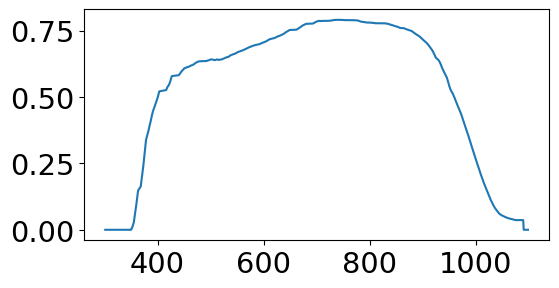

In [20]:
%matplotlib inline
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,tel.transmission(tel_lambdas))

### Config disperser

In [21]:
disp = dispersers.Hologram("holo4_003")

## Load config filename for Auxtel

In [22]:
load_config(config_fullpath)

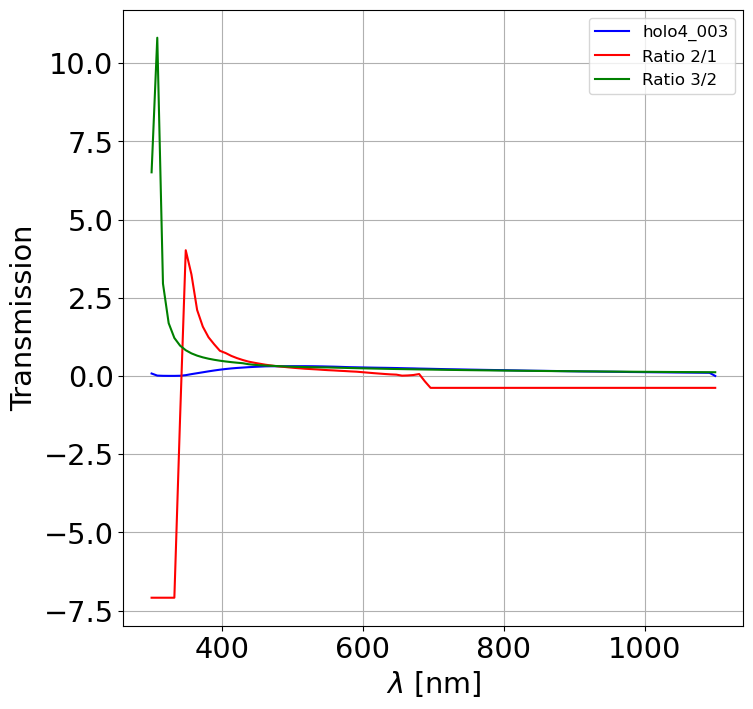

In [23]:
disp.plot_transmission()

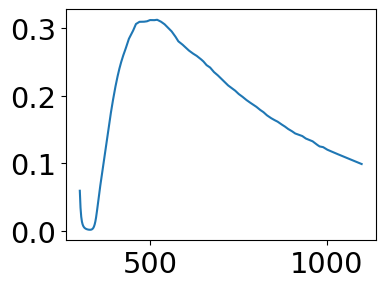

In [24]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,disp.transmission(tel_lambdas))

## Check the presence of the spectra

### select the date of observation in 2022

In [25]:
ALL_DATEOBS = np.array([20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
       20230214, 20230215, 20230216, 20230228, 20230301, 20230302,
       20230314, 20230315, 20230316, 20230509, 20230510, 20230511,
       20230523, 20230524, 20230525, 20230718, 20230720, 20230801,
       20230802, 20230815, 20230817, 20230829, 20230912, 20230913,
       20230914, 20230926, 20230927, 20230928, 20231010, 20231107,
       20231108, 20231113, 20231114, 20231115, 20231116, 20231120,
       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
       20231219, 20231220])

file_out_allfittedparams = "out_allfittedparams.csv"

- Split in 4 parts because too many files open

In [26]:
#ALL_DATEOBS = np.array([20230117, 20230118, 20230119, 20230131, 20230201, 20230202,
#       20230214, 20230215, 20230216, 20230228, 20230301, 20230302,
#       20230314, 20230315, 20230316]) 
#file_out_allfittedparams = "out_allfittedparams_1_4.csv"
                        
#ALL_DATEOBS = np.array([20230509, 20230510, 20230511,
#       20230523, 20230524, 20230525, 20230718, 20230720, 20230801,
#       20230802, 20230815, 20230817, 20230829]) 
#file_out_allfittedparams = "out_allfittedparams_2_4.csv"                        
                        
#ALL_DATEOBS = np.array([20230912, 20230913,
#       20230914, 20230926, 20230927, 20230928, 20231010, 20231107,
#       20231108, 20231113, 20231114, 20231115, 20231116]) 
#file_out_allfittedparams = "out_allfittedparams_3_4.csv"


#ALL_DATEOBS = np.array([20231120,
#       20231127, 20231128, 20231129, 20231130, 20231204, 20231205,
#       20231206, 20231207, 20231211, 20231212, 20231214, 20231215,
#       20231219, 20231220])
#file_out_allfittedparams = "out_allfittedparams_4_4.csv"

In [27]:
YEAR = 2022
all_file_out_allfittedparams = ["out_allfittedparams_2022_1_2.csv","out_allfittedparams_2022_2_2.csv"]

merge_all_file_out_allfittedparams = "out_allfittedparams_2022.csv"

In [28]:
if os.path.isfile(merge_all_file_out_allfittedparams):
    df = pd.read_csv(merge_all_file_out_allfittedparams,index_col=0)
else:
    all_df = [ pd.read_csv(all_file_out_allfittedparams[i]) for i in range(len(all_file_out_allfittedparams))]  
    if len(all_df)>1 :
        df = pd.concat(all_df)
        df.to_csv(merge_all_file_out_allfittedparams)
    else:
        df = all_df[0]
        

In [29]:
df

,DATE-OBS,id,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,TARGET,REDSHIFT,GRATING,...,PWV [mm]_y,PWV [mm]_err_y,reso [pix],reso [pix]_err,D_CCD [mm]_y,D_CCD [mm]_err_y,alpha_pix [pix],alpha_pix [pix]_err,B_y,B_err_y
0,2022-02-16 04:17:39.536874793+00:00,2022021500286,-64,2,1019,3,True,HD42525,0.000059,holo4_003,...,0.000000,0.000000,0.100000,0.000000,186.960593,0.000000,-0.040903,0.0,0.0,0.0
1,2022-02-16 04:18:12.588630829+00:00,2022021500287,-64,2,1016,3,True,HD42525,0.000059,holo4_003,...,0.000000,0.050253,10.000000,0.209851,187.487328,0.041891,-0.301949,0.0,0.0,0.0
2,2022-02-16 04:23:29.730154730+00:00,2022021500296,-64,2,1073,3,True,HD37962,0.000011,holo4_003,...,4.753349,0.210642,1.003730,0.055336,188.532171,0.007196,0.090454,0.0,0.0,0.0
3,2022-02-16 04:24:02.864283317+00:00,2022021500297,-64,2,1072,3,True,HD37962,0.000011,holo4_003,...,4.899293,0.056458,1.005012,0.039020,188.083222,0.006104,1.078012,0.0,0.0,0.0
4,2022-02-16 04:30:36.800905888+00:00,2022021500304,-64,2,1072,3,True,HD38949,0.000011,holo4_003,...,10.000000,0.322370,9.978264,0.429728,191.079352,0.063966,1.575777,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,2022-12-13 02:58:53.731506108+00:00,2022121200415,-64,2,1067,3,True,HD37962,0.000011,holo4_003,...,1.598835,0.033129,2.165987,0.046969,186.796769,0.007405,1.000099,0.0,0.0,0.0
1049,2022-12-13 02:59:52.521998549+00:00,2022121200416,-64,2,1067,3,True,HD38666,0.000364,holo4_003,...,4.788394,7.259914,1.002905,0.444855,187.293526,0.046928,1.246433,0.0,0.0,0.0
1050,2022-12-13 03:00:35.335006654+00:00,2022121200417,-64,2,1067,3,True,HD38666,0.000364,holo4_003,...,5.307348,36.769903,0.998940,0.467241,187.057670,0.034159,1.138605,0.0,0.0,0.0
1051,2022-12-13 03:01:48.221999207+00:00,2022121200418,-64,2,1066,3,True,HD031128,0.000373,holo4_003,...,4.880128,0.115492,1.030408,0.037673,187.488768,0.006403,-0.161165,0.0,0.0,0.0


In [30]:
# convert pandas to numpy rec array
rec = df.to_records()

In [31]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

1221
1184
1141
1022
1012
378


In [32]:
stars = np.unique(rec["TARGET"])
stars

array(['18 Sco', '18Sco', 'BD-113759', 'HD 111980', 'HD 167060',
       'HD 185975', 'HD009051', 'HD031128', 'HD074000', 'HD111980',
       'HD142331', 'HD14943', 'HD160617', 'HD167060', 'HD185975',
       'HD200654', 'HD205905', 'HD2811', 'HD37962', 'HD38666', 'HD38949',
       'HD42525', 'HD60753'], dtype=object)

In [33]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

In [34]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.1,1.9]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,12.]
ATMMINMAX["VAOD_y"] = [0.,0.5]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.1,1.9]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,12.]
ATMMINMAX["VAOD_x"] = [0.,0.5]
ATMMINMAX["A2_x"] = [0.7,1.3]

## Plot fitted parameters

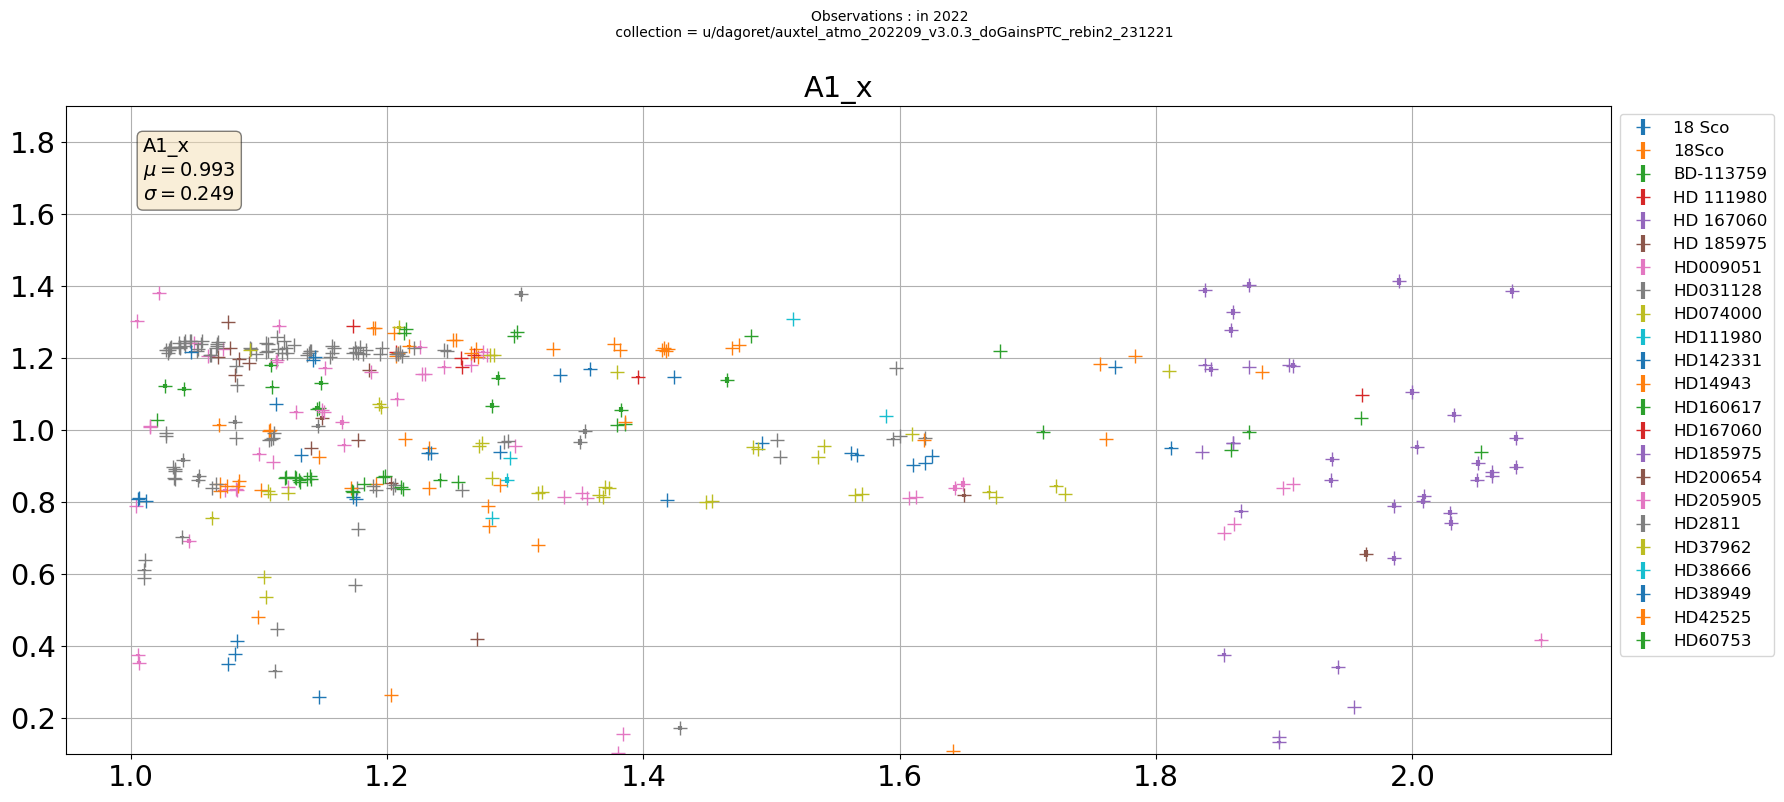

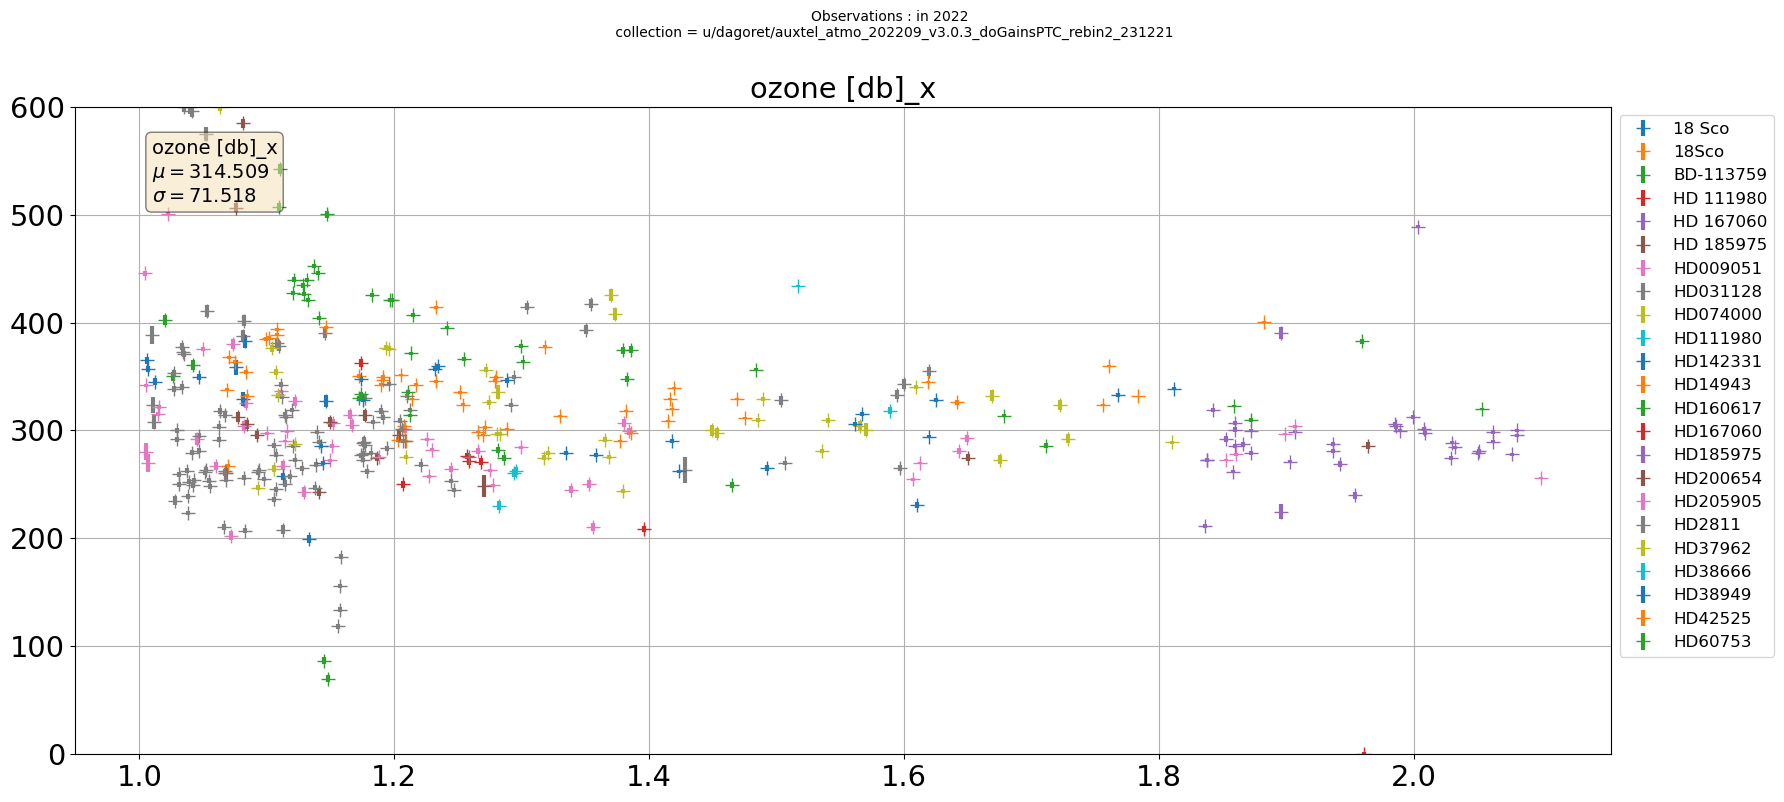

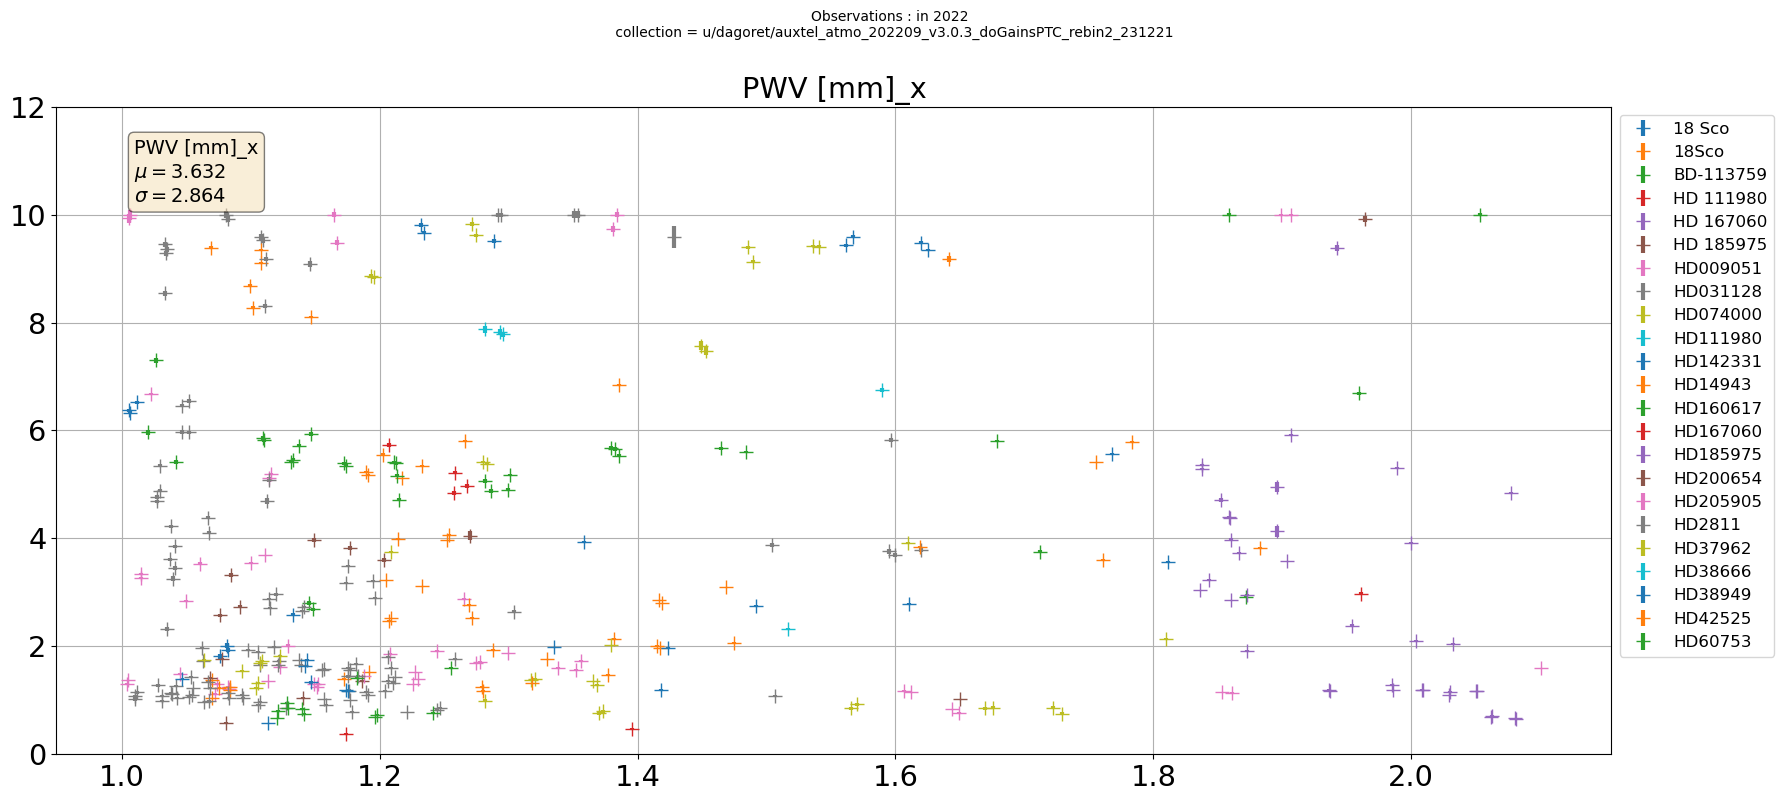

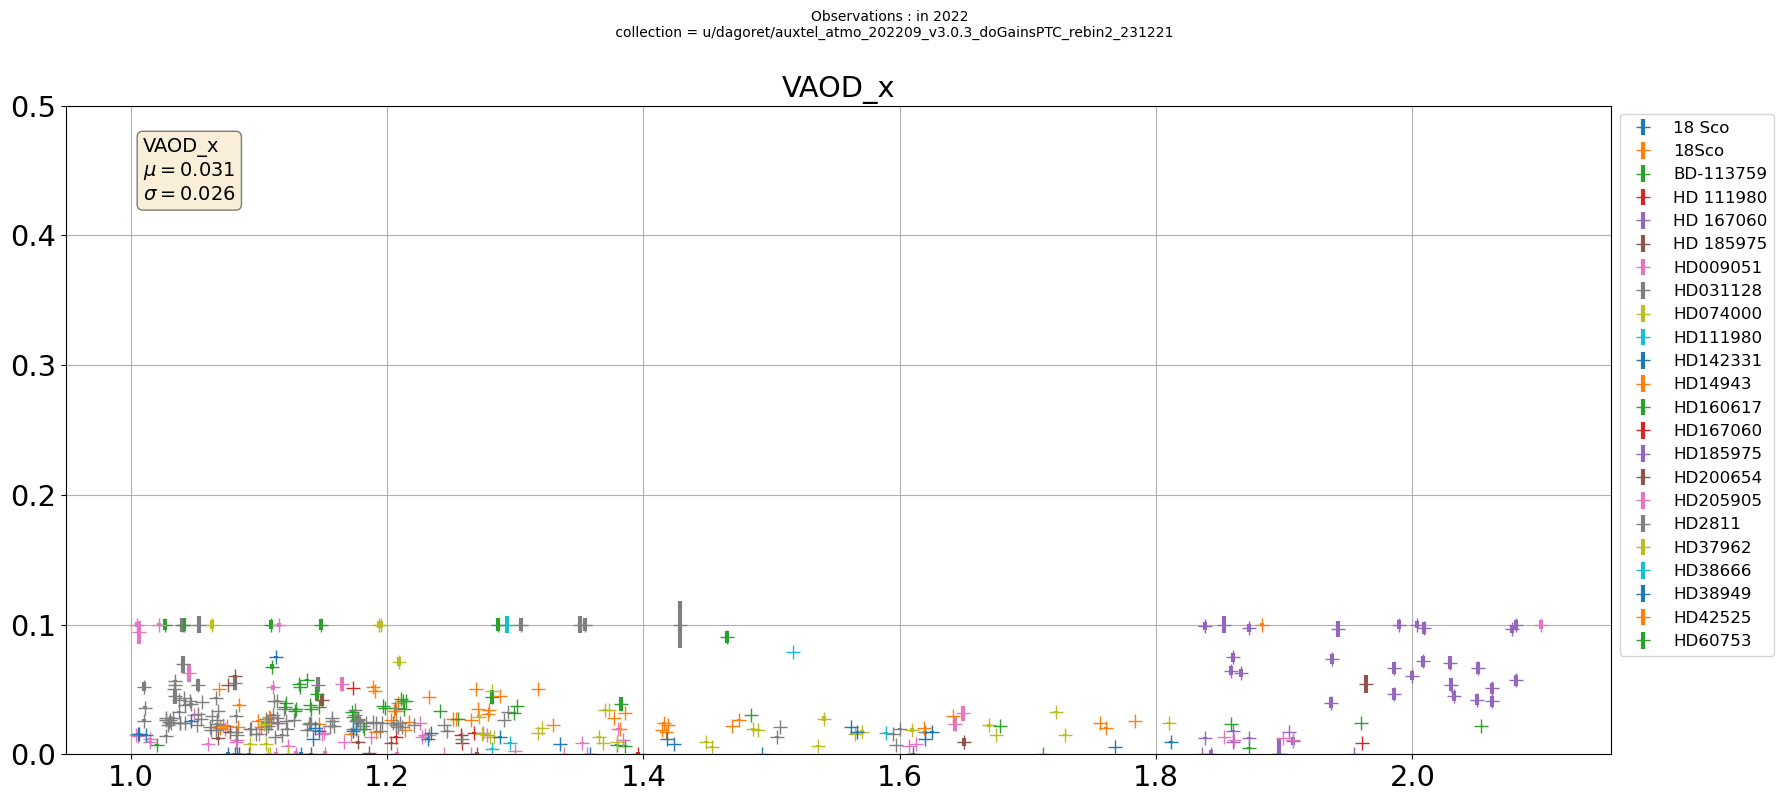

In [35]:
#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x", "gamma_0_1", "gamma_0_2", "alpha_0_1", "alpha_0_2", "y_c_0_1", "y_c_0_2" ]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(18,8))

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))



    for star in stars:
        index = filtered & (rec["TARGET"] == star) & (rec["FILTER"]=="empty")
        if col_err in df.columns:
            plt.errorbar(rec["AIRMASS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=10,lw=3 ,label=star)
        else:
            plt.plot(rec["AIRMASS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3 )
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    #plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in {YEAR} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()


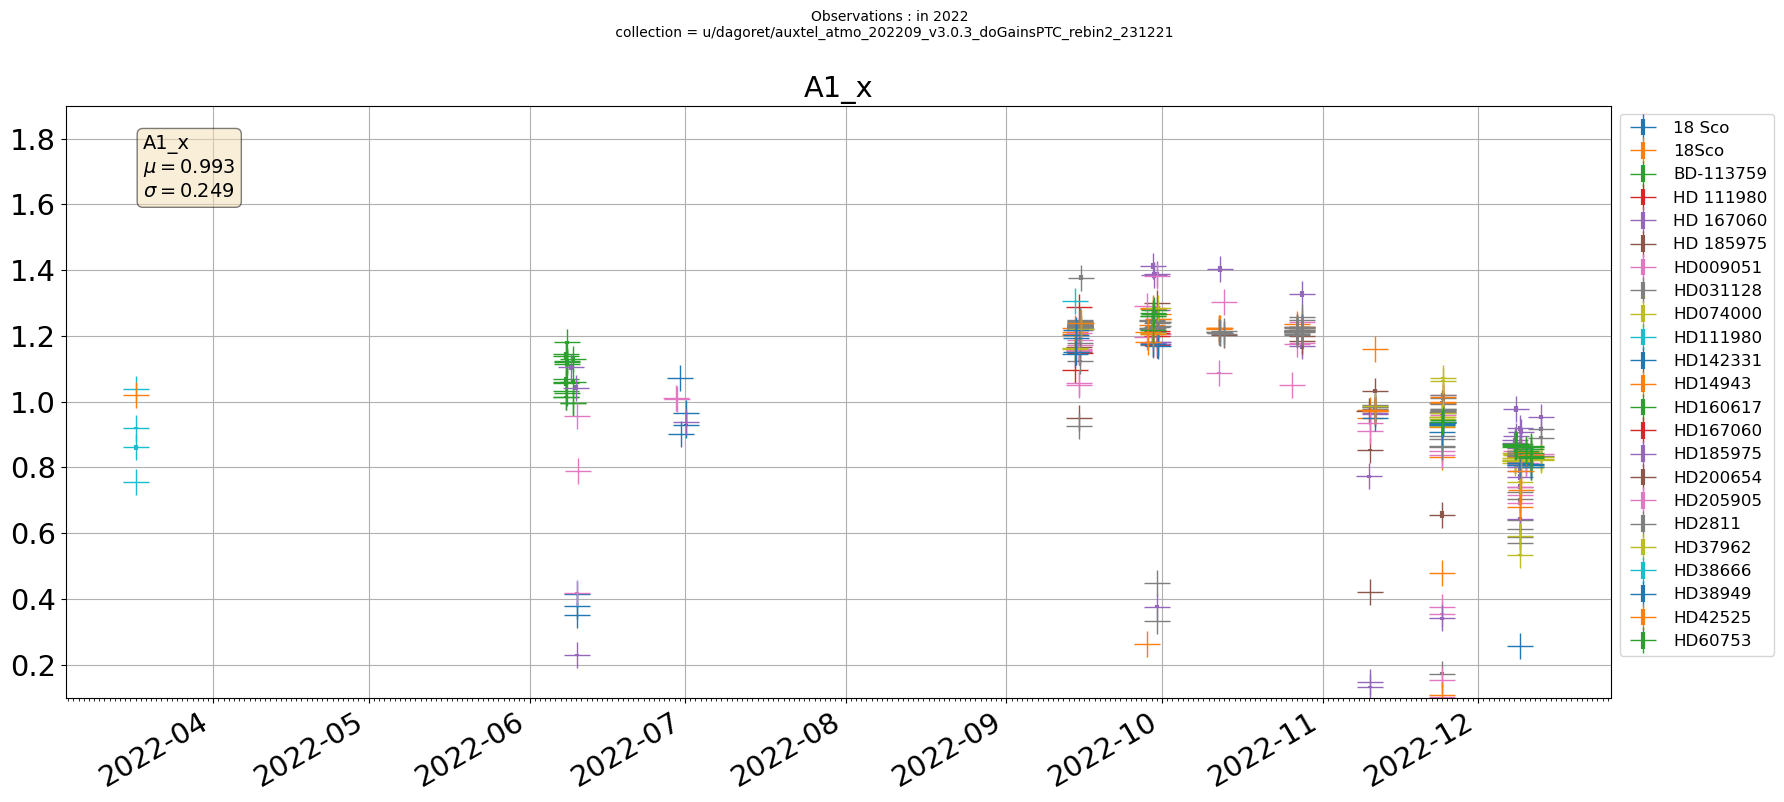

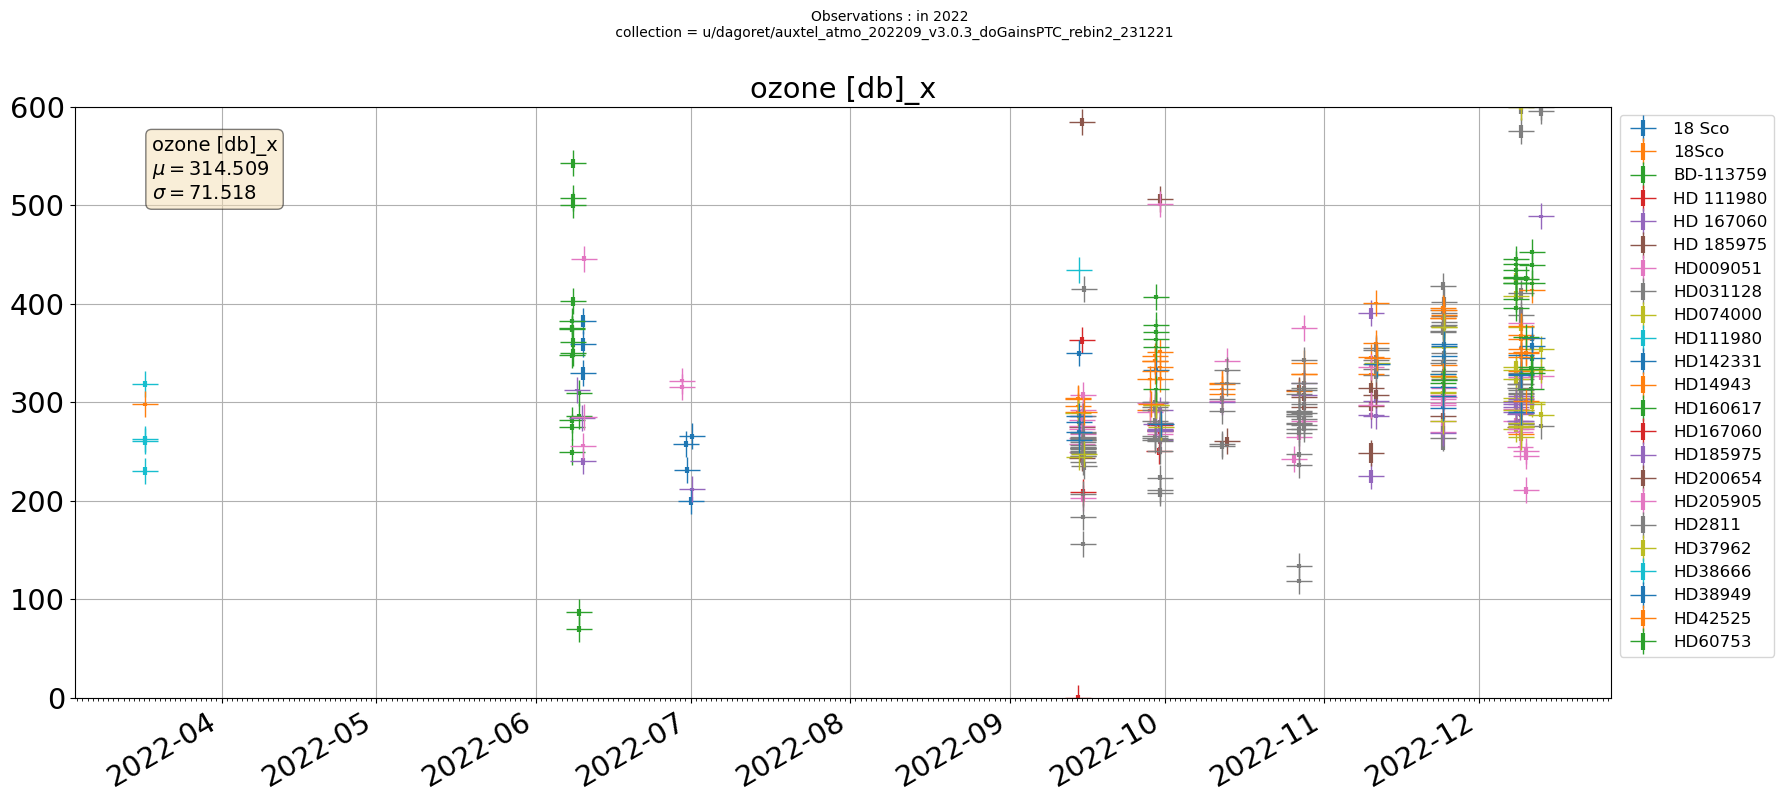

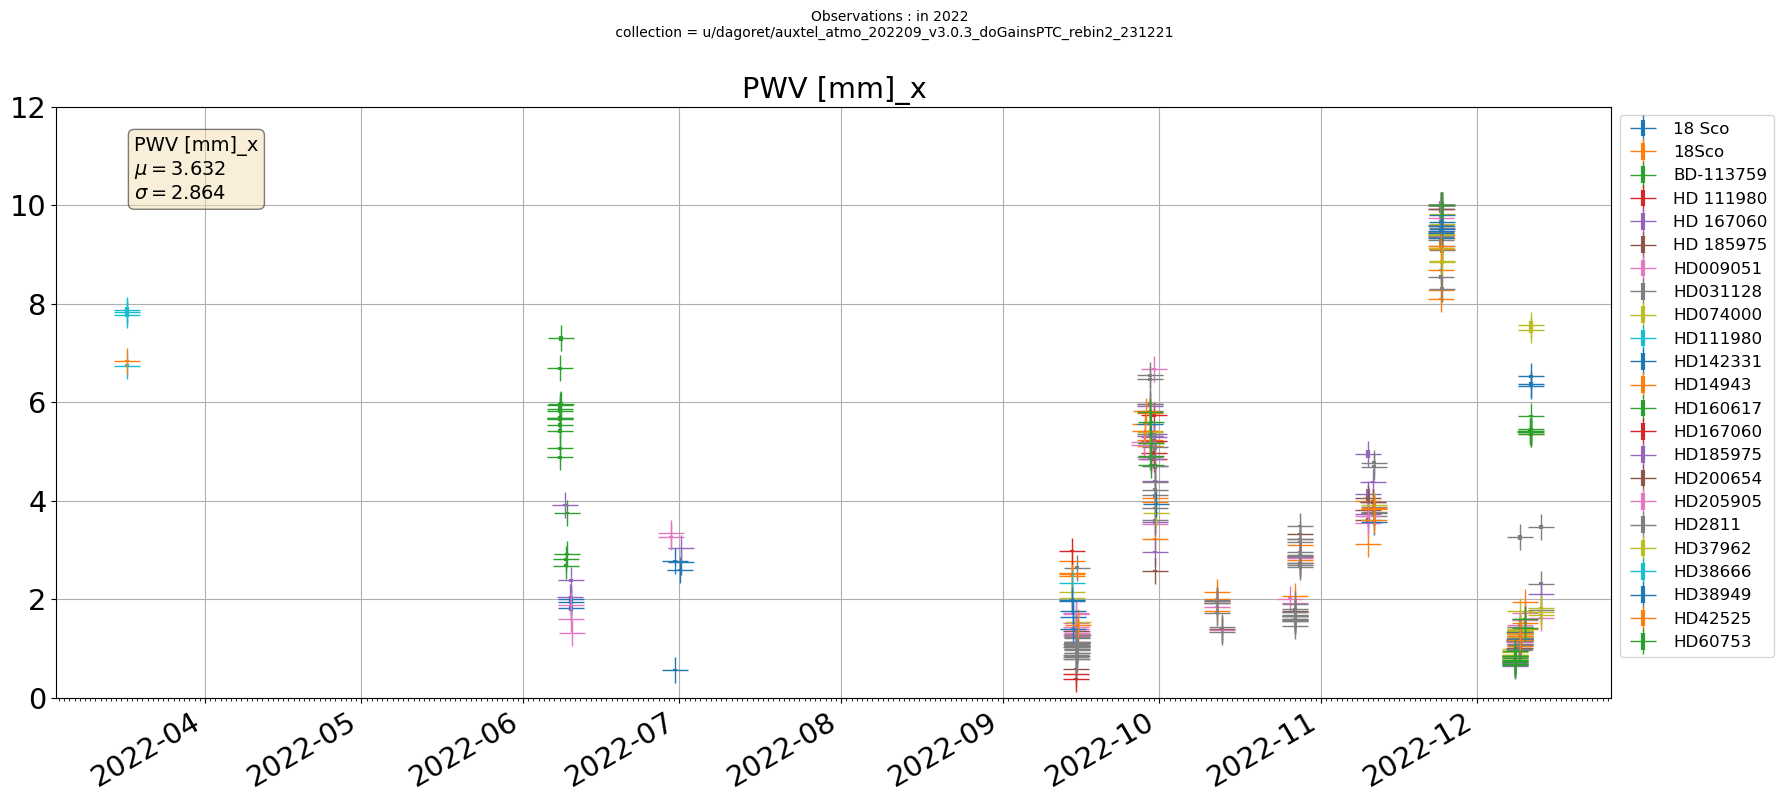

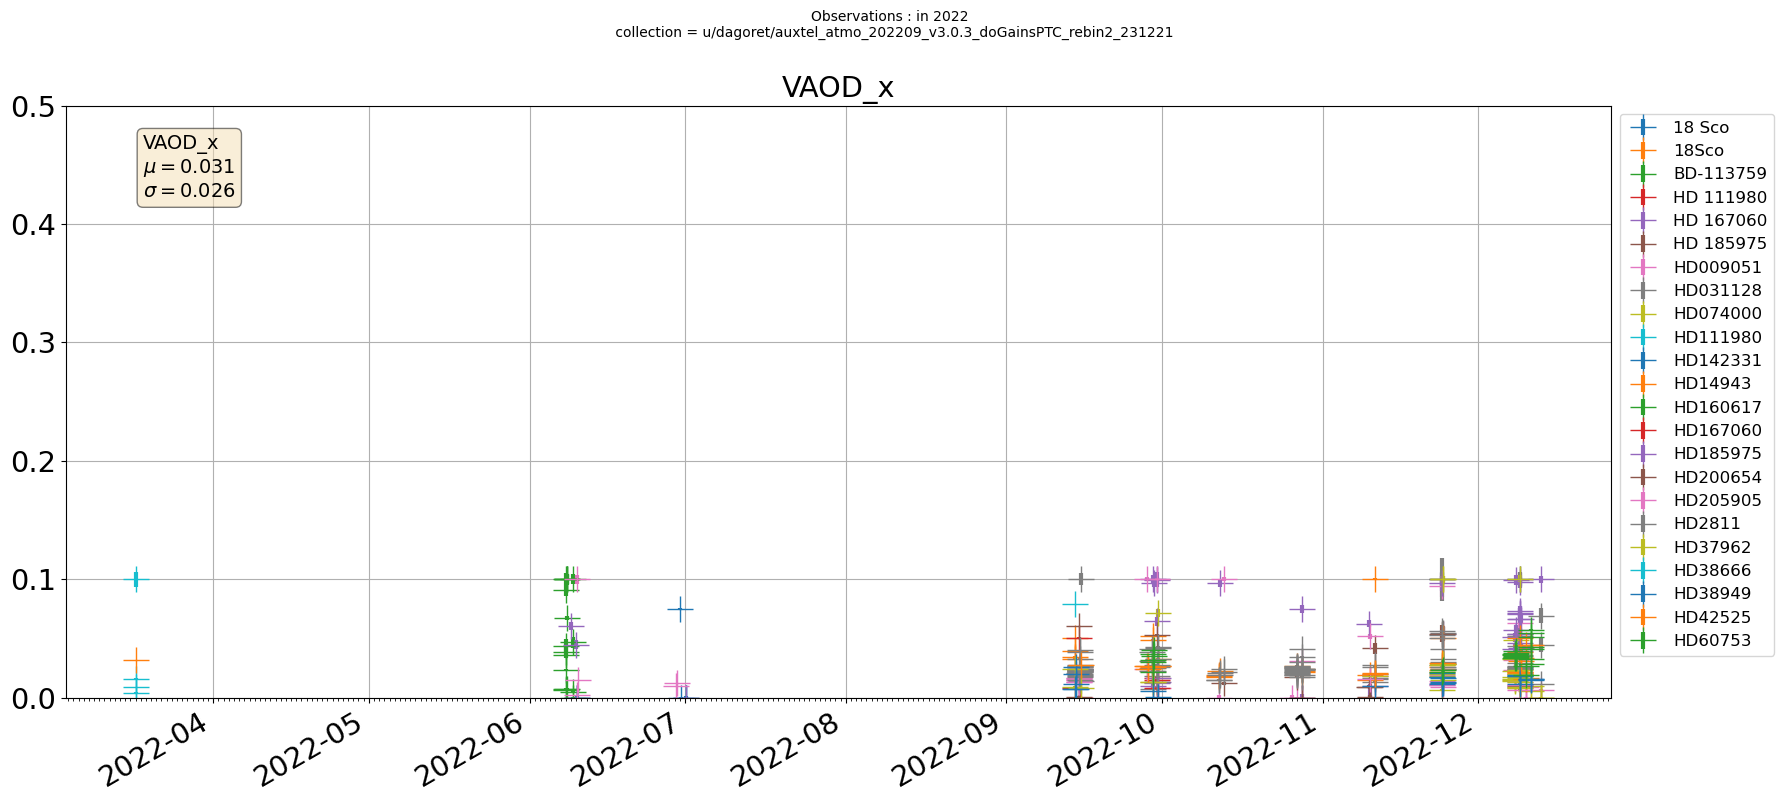

In [36]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(18,8))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in {YEAR} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

In [37]:
rec['DATE-OBS'][index]

array(['2022-09-29 07:12:58.157009345+00:00',
       '2022-09-29 07:49:32.998990475+00:00',
       '2022-09-29 08:39:27.971508252+00:00',
       '2022-09-29 08:40:10.834998220+00:00',
       '2022-09-29 09:13:37.346501297+00:00',
       '2022-09-29 09:14:20.197499442+00:00',
       '2022-11-24 02:45:15.137501964+00:00',
       '2022-11-24 03:07:11.605509620+00:00',
       '2022-12-08 04:26:59.554491889+00:00',
       '2022-12-08 04:46:30.928001068+00:00',
       '2022-12-08 04:47:13.757500996+00:00',
       '2022-12-08 05:19:58.454505196+00:00',
       '2022-12-08 05:20:41.372005603+00:00',
       '2022-12-08 05:28:44.868000607+00:00',
       '2022-12-08 05:29:27.823991336+00:00',
       '2022-12-08 05:35:01.780494619+00:00',
       '2022-12-08 05:35:44.805494287+00:00',
       '2022-12-10 04:13:27.651499466+00:00',
       '2022-12-10 04:46:49.438993010+00:00',
       '2022-12-11 04:27:50.055005806+00:00',
       '2022-12-11 04:28:32.869496709+00:00',
       '2022-12-11 04:47:38.964496

In [38]:
pd.to_datetime(rec['DATE-OBS'][index])

DatetimeIndex(['2022-09-29 07:12:58.157009345+00:00',
               '2022-09-29 07:49:32.998990475+00:00',
               '2022-09-29 08:39:27.971508252+00:00',
               '2022-09-29 08:40:10.834998220+00:00',
               '2022-09-29 09:13:37.346501297+00:00',
               '2022-09-29 09:14:20.197499442+00:00',
               '2022-11-24 02:45:15.137501964+00:00',
               '2022-11-24 03:07:11.605509620+00:00',
               '2022-12-08 04:26:59.554491889+00:00',
               '2022-12-08 04:46:30.928001068+00:00',
               '2022-12-08 04:47:13.757500996+00:00',
               '2022-12-08 05:19:58.454505196+00:00',
               '2022-12-08 05:20:41.372005603+00:00',
               '2022-12-08 05:28:44.868000607+00:00',
               '2022-12-08 05:29:27.823991336+00:00',
               '2022-12-08 05:35:01.780494619+00:00',
               '2022-12-08 05:35:44.805494287+00:00',
               '2022-12-10 04:13:27.651499466+00:00',
               '2022-12-10 0

In [39]:
rec[col][index]

array([0.02147364, 0.03015404, 0.03690972, 0.03214472, 0.04071596,
       0.03524329, 0.02162803, 0.02338726, 0.03331082, 0.03586389,
       0.03692204, 0.03461085, 0.03792858, 0.03526627, 0.03360157,
       0.03921886, 0.03659684, 0.0268911 , 0.01956894, 0.04129224,
       0.04252664, 0.02842423, 0.0326617 , 0.05755428, 0.05160197,
       0.0543717 ])

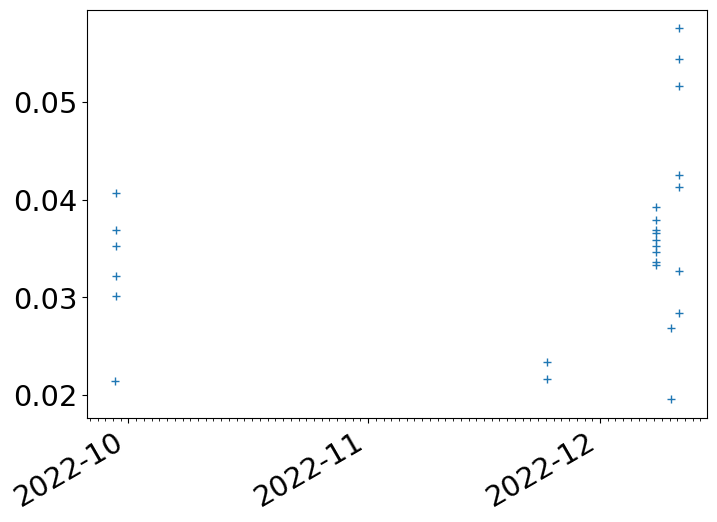

In [40]:
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(pd.to_datetime(rec['DATE-OBS'][index]),rec[col][index],marker='+',lw=0)
ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
fig.autofmt_xdate() # rotation